In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
import cv2
from torch.optim import *
from fastai.callbacks import *
import warnings
warnings.filterwarnings("ignore")
os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = Path("/media/subhaditya/DATA/GITHUB/toxicPlantClass/data/")

In [3]:
def show_2D_act(hook, l=0, nrows=3, ncols=9, s=12):
    """Show nrows*ncols activation visualizations of the l-th layer with figsize s*s"""
    fig, axes = plt.subplots(nrows, ncols, figsize=(s, s / 3))
    fig.subplots_adjust(hspace=0.1, wspace=0, left=0, right=1, top=1, bottom=0)
    for i, ax in enumerate(axes.flat):
        ax.imshow(custom_hook.stored[l][0][i].cpu(), cmap="magma")
        ax.set_axis_off()
# %debug
def create_layer_vis(x, img_path):
    layers = flatten_model(x)
    print(len(layers))
    custom_hook = hook_outputs(layers)

    learn.model.eval()
    img = open_image(img_path)
    learn.predict(img)
    [custom_hook.stored[i].shape for i in range(len(custom_hook.stored))]

    stored_hooks_rank = [
        len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))
    ]
    min_rank = min(
        [len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))]
    )

    for i in range(0, len(layers), 10):
        show_2D_act(custom_hook, i)

In [4]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(max_warp=0.0), size=128)
    )
    .databunch(bs=128)
    .normalize(imagenet_stats)
)

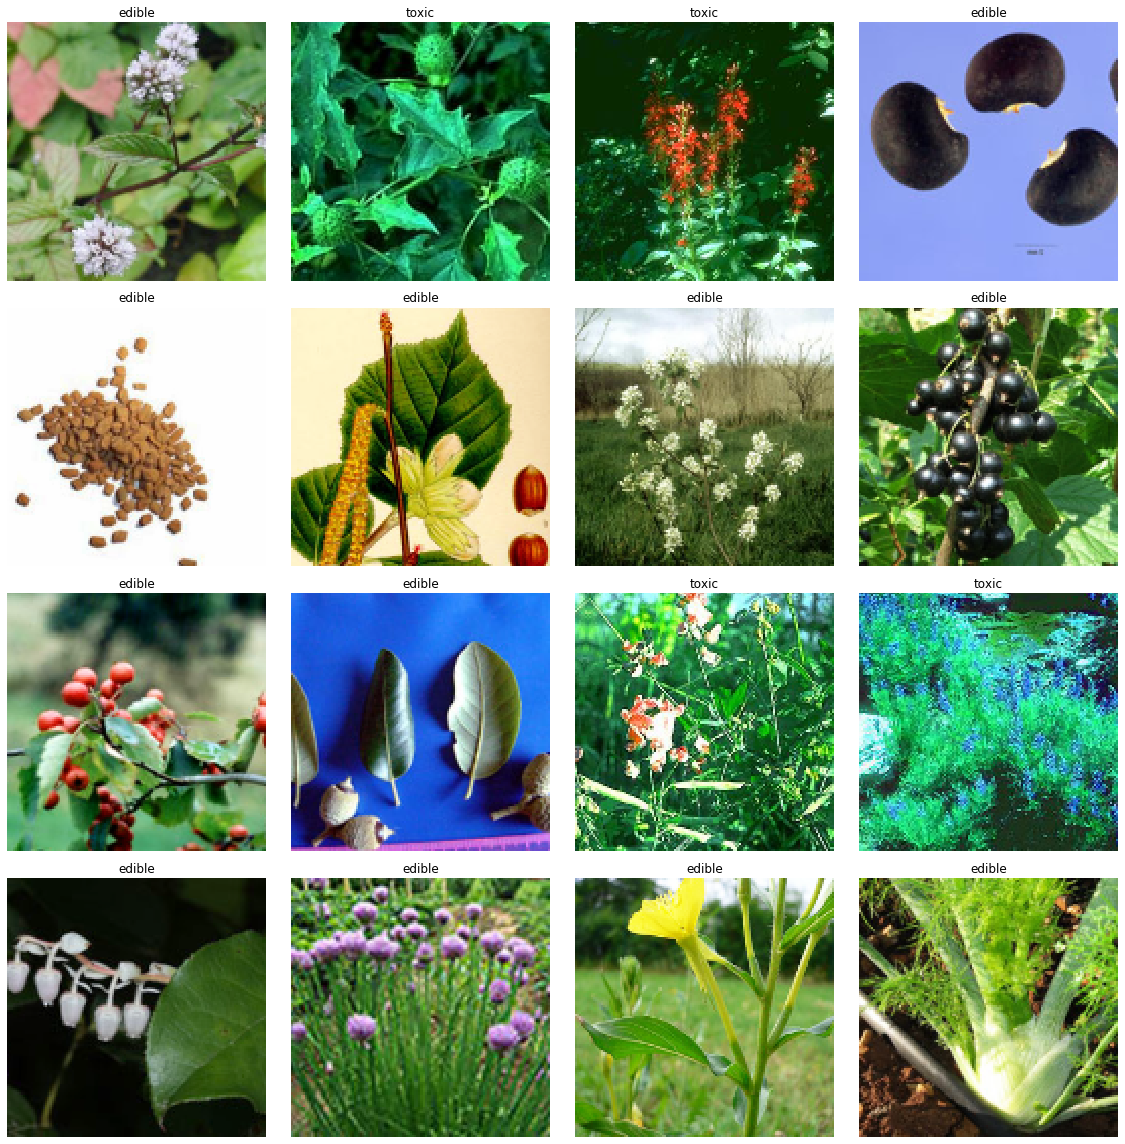

In [5]:
data.show_batch(4)

In [11]:
data.c

2

(array([322.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 186.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

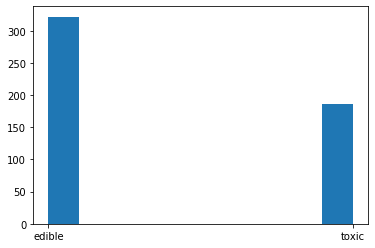

In [23]:
class_sam = [str(x) for x in data.train_ds.y]
plt.hist(class_sam)

In [6]:
learn = None
gc.collect()

35557

In [8]:
from efficientnet_pytorch import EfficientNet
arch = EfficientNet.from_pretrained("efficientnet-b0", advprop=True)
arch._fc = nn.Linear(1280, data.c)
loss_func = LabelSmoothingCrossEntropy()


Loaded pretrained weights for efficientnet-b0


In [9]:
learn = cnn_learner(
    data, models.resnet18, metrics=[accuracy],loss_func=loss_func, opt_func=AdamW, callback_fns=[ShowGraph,OverSamplingCallback]
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


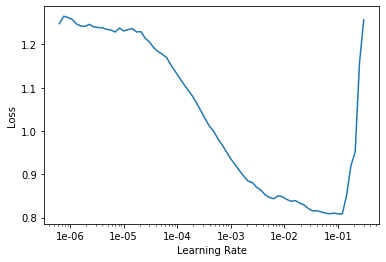

In [36]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.904545,33106480.000000,0.275591,00:03
1,2.073945,27504026.000000,0.275591,00:02
2,2.009346,6439.499023,0.622047,00:01
3,1.848568,43144.589844,0.724409,00:01
4,1.841445,39309.003906,0.275591,00:02
5,1.738700,3101.652344,0.283465,00:02
6,1.647942,47.044445,0.543307,00:01
7,1.557573,6.850002,0.755906,00:02
8,1.586491,7.625772,0.385827,00:02
9,1.512378,4.316221,0.425197,00:01


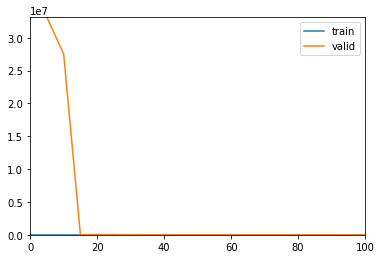

In [37]:
learn.unfreeze()
learn.fit_one_cycle(20, 3e-1, wd=1e-3)

In [41]:
learn.data.y.classes

['edible', 'toxic']

In [11]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (508 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edible,edible,edible,edible,edible
Path: /media/subhaditya/DATA/GITHUB/toxicPlantClass/data;

Valid: LabelList (127 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edible,edible,edible,edible,toxic
Path: /media/subhaditya/DATA/GITHUB/toxicPlantClass/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

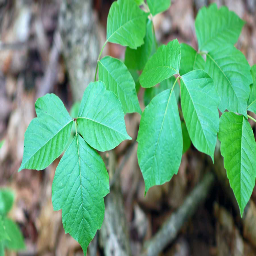

In [44]:
open_image("poi.jpg").resize(256)

In [49]:
str(learn.predict(open_image("poi.jpg").resize(256))[0])

'toxic'

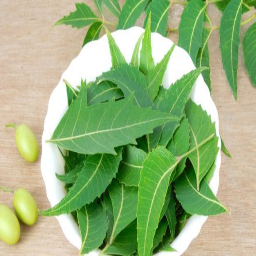

In [46]:
open_image("neem.jpg").resize(256)

In [51]:
str(learn.predict(open_image("neem.jpg").resize(256))[0])

'edible'

# GRAD CAM

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

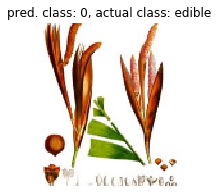

In [13]:
idx = 1
im, cl = learn.data.dl(DatasetType.Valid).dataset[idx]
cl = int(cl)
im.show(
    title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}"
)

In [90]:
def GradCAM(idx:int,interp:ClassificationInterpretation,im,cl, image = True):
    m = interp.learn.model.eval()
    
    
#     im,cl = interp.learn.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    xb,_ = interp.data.one_item(im) #put into a minibatch of batch size = 1
    xb_im = Image(interp.data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cl)].backward() 
    acts  = hook_a.stored[0].cpu() #activation maps
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = ((acts*grad_chan[...,None,None])).sum(0) #F.relu(((acts*grad_chan[...,None,None])).sum(0))
    if image:
        fig,ax = plt.subplots()
        cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
        sz = list(xb_im.shape[-2:])
        xb_im.show(ax,title=f"pred. {str(learn.predict(im)[0])}")
#         fig.colorbar(xb_im)
        im = ax.imshow(mult, alpha=0.7, extent=(0,*sz[::-1],0),
              interpolation='bilinear', cmap='magma')
        fig.colorbar(im, cax=cax, orientation='horizontal')
        plt.show()
    return mult

In [94]:
!pwd

/media/subhaditya/DATA/GITHUB/toxicPlantClass


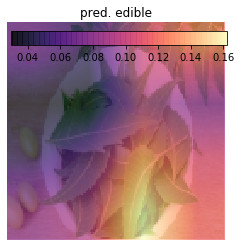

In [91]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp,open_image("neem.jpg").resize(256),1)


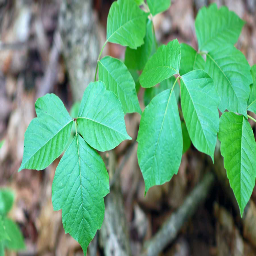

In [92]:
open_image("poi.jpg").resize(256)

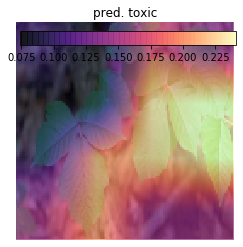

In [93]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp,open_image("poi.jpg").resize(256),1)


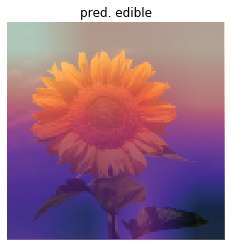

In [96]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp,open_image("sun.jpg").resize(256),1)


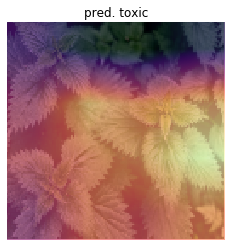

In [97]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp,open_image("nettle.jpeg").resize(256),1)


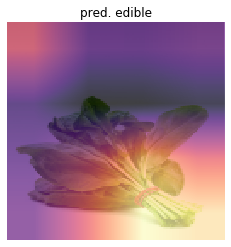

In [98]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp,open_image("spin.jpg").resize(256),1)
